# Gender Classification using Mobilenet v2

## Imports

In [5]:
import matplotlib.pyplot as plt

import pandas as pd
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch


from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm.auto import tqdm

## Paths

In [6]:
img_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
attributes_file = '/kaggle/input/celeba-dataset/list_attr_celeba.csv'
partition_file = '/kaggle/input/celeba-dataset/list_eval_partition.csv'

## Transforms

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

## Prepare dataset

In [7]:
attr_df = pd.read_csv(attributes_file)
partition_df = pd.read_csv(partition_file)

merged_df = pd.merge(attr_df[['image_id', 'Male']], partition_df, on="image_id")
train_df = merged_df[merged_df['partition'] == 0]

image_label_mapping = {os.path.join(img_dir, row['image_id']): 1 if row['Male'] > 0 else 0 for _, row in train_df.iterrows()}


In [8]:
class CelebADataset(Dataset):
    def __init__(self, image_label_mapping, transform=None):
        """
        Args:
            image_label_mapping (dict): A dictionary mapping image paths to labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_label_mapping = image_label_mapping
        self.transform = transform
        self.image_paths = list(image_label_mapping.keys())

    def __len__(self):
        return len(self.image_label_mapping)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = read_image(image_path)
        label = self.image_label_mapping[image_path]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [9]:
image_paths = list(image_label_mapping.keys())
labels = list(image_label_mapping.values())

train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

train_mapping = dict(zip(train_paths, train_labels))
val_mapping = dict(zip(val_paths, val_labels))

In [10]:
train_dataset = CelebADataset(image_label_mapping=train_mapping, transform=transform)
val_dataset = CelebADataset(image_label_mapping=val_mapping, transform=transform)

NameError: name 'transform' is not defined

In [ ]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


## Create pretrained model

In [12]:
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 81.6MB/s]


## Set optimizer and loss func

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

## Write train func that includes val and train dataloaders

In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    print(device)
    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # For each epoch training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  #
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            data_loader = tqdm(dataloaders[phase], desc=f'{phase} Phase')
            
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print()

    return model, history

## Plot acc and loss history

In [3]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    train_loss = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in history['train_loss']]
    val_loss = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in history['val_loss']]
    train_acc = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in history['train_acc']]
    val_acc = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in history['val_acc']]
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    
    plt.show()

## Train model

In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}

model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=2)

In [4]:
plot_training_history(history)

NameError: name 'history' is not defined

## Save model

In [18]:
torch.save(model.state_dict(), 'model_weights.pth')

## Load model

In [12]:
!wget https://github.com/Dimildizio/DS_course/raw/main/Neural_networks/Convolutions/data/babka_mobilenet.pth -O babka.pth

--2024-04-02 22:45:43--  https://github.com/Dimildizio/DS_course/raw/main/Neural_networks/Convolutions/data/babka_mobilenet.pth
Resolving github.com (github.com)... 20.248.137.48
Connecting to github.com (github.com)|20.248.137.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Convolutions/data/babka_mobilenet.pth [following]
--2024-04-02 22:45:43--  https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Convolutions/data/babka_mobilenet.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9151922 (8.7M) [application/octet-stream]
Saving to: 'babka.pth'

babka.pth           100%[===================>]   8.73M  --.-KB/s    in 0.03s   

In [13]:
model = models.mobilenet_v2(pretrained=False)  
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('babka.pth'))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [14]:
!wget https://upload.wikimedia.org/wikipedia/en/thumb/7/7d/Lenna_%28test_image%29.png/330px-Lenna_%28test_image%29.png -O lenna.png
!wget https://t3.ftcdn.net/jpg/02/43/12/34/360_F_243123463_zTooub557xEWABDLk0jJklDyLSGl2jrr.jpg -O dude.jpg
!wget https://hackspirit.com/wp-content/uploads/2021/06/Copy-of-Rustic-Female-Teen-Magazine-Cover.jpg -O magaz.jpg    
!wget https://cdn2.psychologytoday.com/assets/styles/manual_crop_1_91_1_1528x800/public/field_blog_entry_images/2018-09/shutterstock_648907024.jpg -O grl1.jpg
! wget https://www.georgetown.edu/wp-content/uploads/2022/02/Jkramerheadshot-scaled-e1645036825432-1050x1050-c-default.jpg -O grl2.jpg
! wget https://www.jordanharbinger.com/wp-content/uploads/2018/09/be-the-most-interesting.jpg -O dude2.jpg
! wget https://www.mnp.ca/-/media/foundation/integrations/personnel/2020/12/16/13/57/personnel-image-4483.jpg -O dude3.jpg
! wget https://experteditor.com.au/wp-content/uploads/2023/07/signs-youre-a-great-person.png -O grl3.png

--2024-04-02 22:48:15--  https://upload.wikimedia.org/wikipedia/en/thumb/7/7d/Lenna_(test_image).png/330px-Lenna_(test_image).png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194198 (190K) [image/png]
Saving to: 'lenna.png'

lenna.png           100%[===================>] 189.65K   598KB/s    in 0.3s    

2024-04-02 22:48:16 (598 KB/s) - 'lenna.png' saved [194198/194198]



## Test images

In [85]:
from PIL import Image, ImageDraw, ImageFont

font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
font_size = 20
font = ImageFont.truetype(font_path, font_size)
text_width, text_height = draw.textsize('Проститутка', font=font)


def draw_text(image, text):
    image.thumbnail((480, 480))
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size
    
    x = (image_width-text_width) // 2
    y = 10
    position = (x, y) 

    
    color = 'rgb(250, 10, 10)'  

    draw.text(position, text, fill=color, font=font)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


/tmp/ipykernel_34/1004458863.py:6: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize('Проститутка', font=font)


In [49]:
!ls

Copy-of-Rustic-Female-Teen-Magazine-Cover.jpg  dude2.jpg  grl2.jpg   magaz.jpg
babka.pth				       dude3.jpg  grl3.png
dude.jpg				       grl1.jpg   lenna.png


In [ ]:
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [56]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_random_image(img=None, directory=''):
    if not img:
        random_filename = random.choice(os.listdir(directory))
        img = os.path.join(directory, random_filename)
    img = Image.open(img).convert('RGB')
    return img

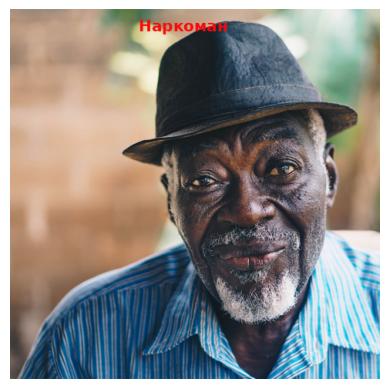

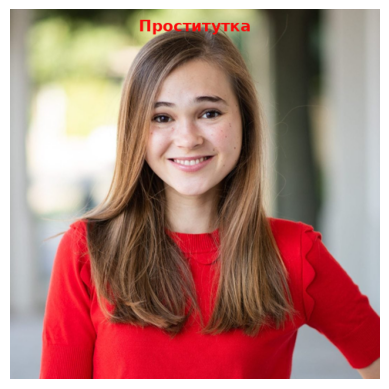

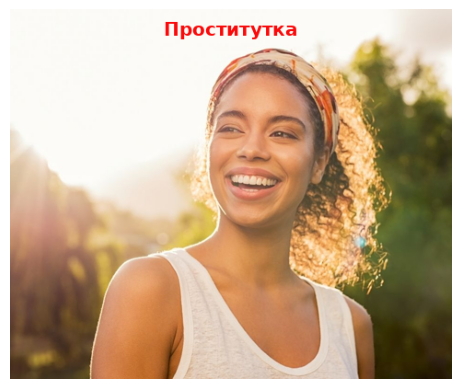

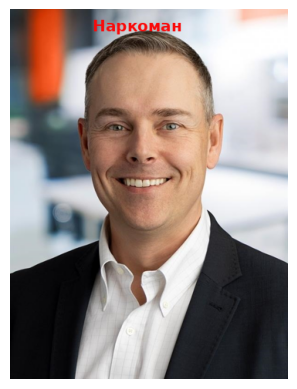

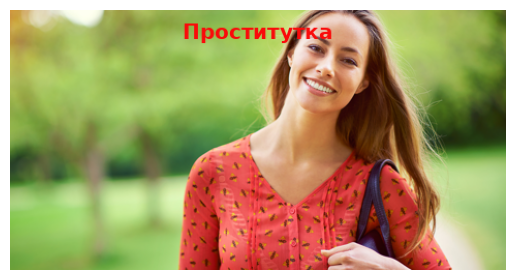

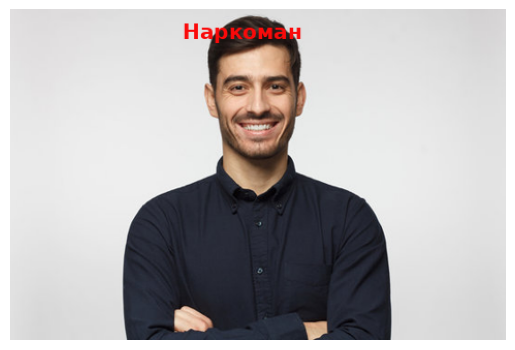

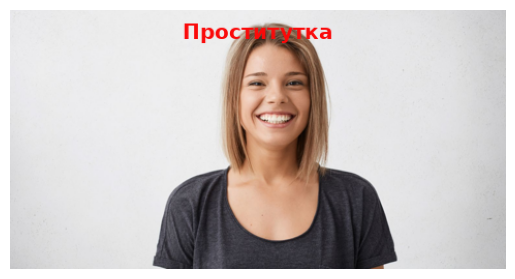

In [87]:
with torch.no_grad():
    imgs = ['dude2.jpg', 'grl2.jpg', 'magaz.jpg', 'dude3.jpg',  'grl3.png', 'dude.jpg', 'grl1.jpg']
    for img in imgs:
        image = load_random_image(img)
        image_transformed = transform(image)

                
        result = model(image_transformed.unsqueeze(0).to(device))
        _, preds = torch.max(result, 1)
        draw_text(image, 'Наркоман' if preds else 'Проститутка')